# MTH793P - Coursework 2

This is a template notebook for the computational exercises of Coursework #2 of the module MTH793P, Advanced Machine Learning.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import linalg
from matplotlib.colors import ListedColormap
from sklearn.datasets import make_moons

from numpy.testing import assert_array_almost_equal
from numpy.testing import assert_equal
from numpy.testing import assert_array_equal

With the following cell, we generate samples from a dataset known as 'Two moons'. We will later try to identify from which half-moon a sample originates in a fully unsupervised fashion. We store *num_points* samples in a matrix *X* and the corresponding labels in a vector *y*. We visualise the dataset with PyPlot.

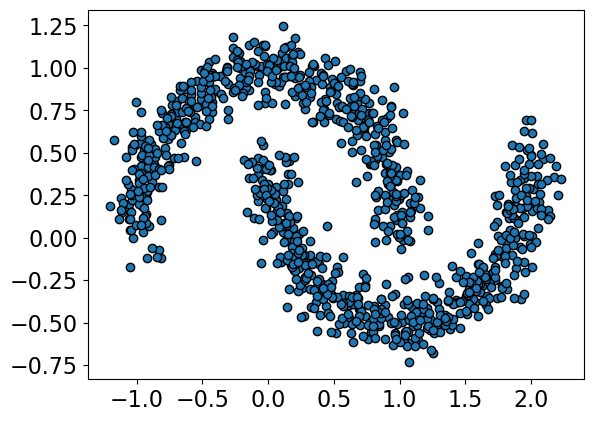

In [2]:
seed = 13
np.random.seed(seed)
num_points = 1000
X, y = make_moons(n_samples=num_points, noise=0.1, random_state=seed)
plt.scatter(X[:, 0], X[:, 1],  edgecolors='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

In order to do so, we will builda weighted graph with weights based on the pairwise Euclidean distances between samples. For this, we write a function **pairwise_distances** that takes two arguments *argument1* and *argument2* that are NumPy arrays for which the first dimension equals the number of samples and the second dimension the dimension of each sample. The function should return the pairwise Euclidean distances between the points in the arrays. You can make use of any of the pairwise-distance functions that you have already implemented in MTH786P.

In [3]:
def pairwise_distances(argument1, argument2):
    ### BEGIN SOLUTION
    N = argument1.shape[0]
    M = argument2.shape[0]
    D = np.zeros((N,M))
    for i in range(N):
        for j in range(M):
            x = argument1[i]
            y = argument2[j]
            D[i,j] = np.sqrt(np.sum((x-y)**2))
    return D
    ### END SOLUTION

Use your function *pairwise_distances* to compute the pairwise distances between *X* and *X* itself and store these distances in an array named *distance_matrix*. 

In [4]:
### BEGIN SOLUTION
distance_matrix = pairwise_distances(X, X)
### END SOLUTION

Use these pairwise distances to compute the weights *graph_weights* of your graph via the equation

$$ \text{graph_weights}_{ij} = \begin{cases} \exp(-\gamma \| x_i - x_j \|) & \exp(-\gamma \| x_i - x_j \|) \geq \tau \\ 0 & \text{otherwise} \end{cases} \, , $$

for $i, j \in \{1, \ldots, \text{num_points}\}$. Here $\gamma$ and $\tau$ are positive constants that control the sparsity of the graph. Write a function **create_graph_weights** that takes three arguments *distance_matrix*, *gamma* and *tau* and returns an argument *graph_weights*.

In [5]:
def create_graph_weights(distance_matrix, gamma, tau):
    ### BEGIN SOLUTION
    graph_weights = np.exp(-gamma*distance_matrix)
    graph_weights[graph_weights < tau] = 0    
    return graph_weights
    ### END SOLUTION

Create weights *graph_weights* based on your pairwise distances *distance_matrix* for choices $\gamma = 3.5$ and $\tau = 10^{-1}$.

In [6]:
### BEGIN SOLUTION
gamma = 3.5
tau = 1e-1
graph_weights = create_graph_weights(distance_matrix, gamma, tau)
### END SOLUTION

The following cell tests your code for test specific choices of *gamma* and *tau*.

In [7]:
test_matrix = X[[70, 320, 785], :]
test_weights = create_graph_weights(pairwise_distances(test_matrix, test_matrix), 1.5, tau)
assert_array_almost_equal(test_weights, [[1, 0, 0.18847515], [0, 1, 0.23472212], [0.18847515, 0.23472212,1]])

test_matrix = X[[62, 358, 892], :]
test_weights = create_graph_weights(pairwise_distances(test_matrix, test_matrix), 1.9, tau)
assert_array_almost_equal(test_weights, [[1, 0, 0.31715922],[0, 1, 0], [0.31715922, 0,1]])

assert_array_equal(graph_weights.shape, [num_points,num_points])

Next, we use the graph weights to compute the incidence matrix of the graph. For this we modify the function **construct_incidence_matrix** from Coursework-1 as follows: instead of  the argument *nodes* the modified version takes the argument *num_nodes*. Note that the function allows entries of *weights* to be zero, resulting in some rows of the incidence matrix to be zero. All zero rows should therefore be removed before the incidence matrix is returned. How do you identify the row-indices for which the rows are zero? Use your favourite search engine or the SciPy help.

In [8]:
def construct_incidence_matrix(num_nodes, edges, weights):
    ### BEGIN SOLUTION
    num_edges = len(edges)
    incidence_matrix = np.zeros((num_edges, num_nodes))
    for index in range(num_edges):
        indices = edges[index]    
        w = weights[indices[0],indices[1]]
        incidence_matrix[index, indices[0]] = -np.sqrt(w)
        incidence_matrix[index, indices[1]] = np.sqrt(w)
    return incidence_matrix[np.count_nonzero(incidence_matrix,1)>0]
    ### END SOLUTION

Define a list *edges* of edges between all nodes that matches the order to the weights *graph_weights* defined earlier.

In [9]:
### BEGIN SOLUTION
edges = [[i, j] for i in range(num_points) for j in range(i+1,num_points)]
### END SOLUTION````````````````

Construct the incidence matrix *incidence_matrix* via **construct_incidence_matrix** for your edges *edges* and weights *graph_weights*. The number of nodes should match the number of samples *num_samples*.

In [10]:
### BEGIN SOLUTION
incidence_matrix = construct_incidence_matrix(num_points, edges, graph_weights)
### END SOLUTION

The following cell tests your code.

In [11]:
assert_array_equal(incidence_matrix.shape, (103720.0, num_points))

test_edges = [[i, j] for i in range(3) for j in range(3) if i < j]
test_incidence_matrix = construct_incidence_matrix(3, test_edges, test_weights)

F = 1
try:
    assert_array_almost_equal(test_incidence_matrix, np.array([[-0.56316891, 0, 0.56316891]]))
    F = 0
except:
    pass

try:
    assert_array_almost_equal(test_incidence_matrix, np.array([[0.56316891, 0, -0.56316891]]))
    F = 0
except:
    pass

assert_equal(F,0)

Define the corresponding graph-Laplacian and store it in a variable named *graph_laplacian*.

In [12]:
### BEGIN SOLUTION
graph_laplacian = incidence_matrix.T @ incidence_matrix
### END SOLUTION

The graph_laplacian has 208440 non-zero out of 1000000 entries.


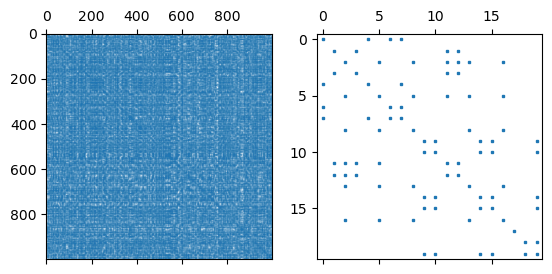

In [13]:
print('The graph_laplacian has {nz} non-zero out of {t} entries.'.format(nz=np.count_nonzero( \
        graph_laplacian), t=num_points ** 2))
plt.subplot(1, 2, 1)
plt.spy(graph_laplacian, markersize=0.05)
plt.subplot(1, 2, 2)
plt.spy(graph_laplacian[:20, :20], markersize=2)
plt.tight_layout;

Compute the first two smallest eigenvalues and corresponding eigenvectors and store them in the variables *eigenvalues* and, respectively, *eigenvectors*.

In [14]:
### BEGIN SOLUTION
eigenvalues, eigenvectors = linalg.eigs(graph_laplacian, k=2, which='SM')
### END SOLUTION

The following cell tests your code.

In [15]:
assert_array_almost_equal(eigenvalues, [0, 1.604139355])
print('The two smallest eigenvalues of the graph-Laplacian are λ0 = {l0:.4f} and λ1 = {l1:.4f}.'.format( \
        l0=eigenvalues[0].real, l1=eigenvalues[1].real))

test_graph_laplacian = test_incidence_matrix.T @ test_incidence_matrix
test_eigenvalues, _ = np.linalg.eig(test_graph_laplacian)
assert_array_almost_equal(test_eigenvalues, [0.6343185, 0, 0])

The two smallest eigenvalues of the graph-Laplacian are λ0 = 0.0000 and λ1 = 1.6041.


Use the second eigenvector to create a Boolean vector *unsupervised_labels* for visualisation of the two moons dataset. What do you observe? How could results be improved?

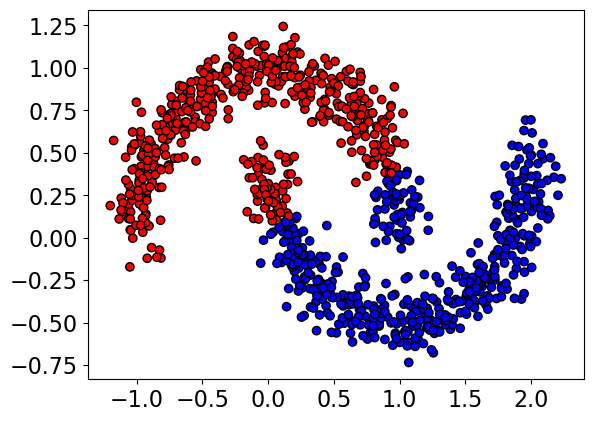

In [16]:
### BEGIN SOLUTION
unsupervised_labels = np.real(eigenvectors[:, 1]) > 0
### END SOLUTION
colormap_bright = ListedColormap(['#FF0000', '#0000FF'])

plt.scatter(X[:, 0], X[:, 1], c=unsupervised_labels, cmap=colormap_bright, edgecolors='k')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16);

This concludes this week's coursework.

In [17]:
from sklearn.cluster import KMeans
KM = KMeans(n_clusters=2,n_init=1, max_iter=100)
KM.fit(X)
L = KM.predict(X)
C = KM.cluster_centers_

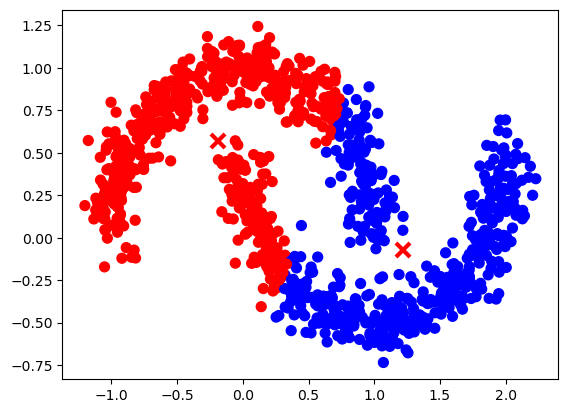

In [18]:
plt.scatter(X[:, 0], X[:, 1], c=L, s=50, cmap=colormap_bright)
plt.plot(C[:, 0], C[:, 1], 'x', c='red', markersize=10, markeredgewidth=3)